### Model (Neural Network)

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path 
from utils import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Type hinting
from typing import Tuple
# Supress arnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load datasets 

In [114]:
# Datasets 
train_data_path = Path("./dataset/train_extended.csv") 
test_data_path = Path("./dataset/test.csv") 
train_data = pd.read_csv(train_data_path, encoding='utf-8', index_col='Loan_ID')
test_data = pd.read_csv(test_data_path, encoding='utf-8', index_col='Loan_ID')

train_data = train_data.drop('Credit_History', axis=1)
test_data = test_data.drop('Credit_History', axis=1)

In [117]:
X_train, y_train, X_test = get_train_test_data(train_data, test_data)

In [129]:
X_train.dtypes

Gender                   int64
Married                  int64
Dependents               int64
Education                int64
Self_Employed            int64
ApplicantIncome        float64
CoapplicantIncome      float64
LoanAmount             float64
Loan_Amount_Term       float64
Property_Area            int64
Total_Income           float64
EMI                    float64
DTI                    float64
Debt_to_Income         float64
Income_Per_Capita      float64
Income_to_EMI_Ratio    float64
dtype: object

### Functions for model creation

In [118]:
def create_neural_network_model(input_shape: int) -> tf.keras.Model:
    """
    Create and compile a neural network model.
    """
    KERNEL_REGULARIZER_PARAM: float = 1e-3
    model = Sequential([
        # Input(shape=(input_shape,)), 
        Dense(64, activation='relu', 
              input_shape=(input_shape,), 
              kernel_regularizer=l2(KERNEL_REGULARIZER_PARAM)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(48, activation='relu', kernel_regularizer=l2(KERNEL_REGULARIZER_PARAM)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu', kernel_regularizer=l2(KERNEL_REGULARIZER_PARAM)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=0.001, decay=1e-6)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy', 
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

### Functions for training network 

In [107]:
def train_neural_network(X_train: np.ndarray, y_train: pd.Series
                        ) -> Tuple[tf.keras.Model, np.ndarray, np.ndarray]:
    """
    Split the training data, create the neural network model, and train it.
    """
    # Split data into training and validation sets
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Create model
    model = create_neural_network_model(input_shape=X_tr.shape[1])
    
    # Set up callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=50, 
        restore_best_weights=True,
        min_delta=0.001
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-6
    )
    
    # Train model
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return model, X_val, y_val

def evaluate_model(model: tf.keras.Model, X_val: np.ndarray, y_val: pd.Series) -> None: 
    """
    Evaluates the trained model on the validation set and prints performance metrics.

    Parameters:
        model (tf.keras.Model): Trained model.
        X_val (np.ndarray): Validation features.
        y_val (pd.Series): Validation target.
    """
    y_pred_proba = model.predict(X_val).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    print("Validation Metrics:")
    print(classification_report(y_val, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print(f"\nROC AUC Score: {roc_auc_score(y_val, y_pred_proba):.4f}")
    print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")


### Main

In [119]:
# Train the neural network and obtain validation data
model, X_val, y_val = train_neural_network(X_train, y_train)


Epoch 1/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5315 - auc: 0.5112 - loss: 0.9194 - precision_8: 0.7046 - recall_8: 0.5656 - val_accuracy: 0.6825 - val_auc: 0.4895 - val_loss: 0.7382 - val_precision_8: 0.6961 - val_recall_8: 0.9640 - learning_rate: 0.0010
Epoch 2/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6496 - auc: 0.5199 - loss: 0.7501 - precision_8: 0.7095 - recall_8: 0.8574 - val_accuracy: 0.6950 - val_auc: 0.4896 - val_loss: 0.7160 - val_precision_8: 0.6950 - val_recall_8: 1.0000 - learning_rate: 0.0010
Epoch 3/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6662 - auc: 0.5188 - loss: 0.7349 - precision_8: 0.6982 - recall_8: 0.9232 - val_accuracy: 0.6950 - val_auc: 0.4854 - val_loss: 0.7065 - val_precision_8: 0.6950 - val_recall_8: 1.0000 - learning_rate: 0.0010
Epoch 4/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6757 - auc: 0.4915 - loss: 0.7276 - precision_8: 0.6968 - recall_8: 0.9514 - val_accuracy: 0.6933 - val_auc:

In [120]:
evaluate_model(model, X_val, y_val)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       366
           1       0.69      1.00      0.82       834

    accuracy                           0.69      1200
   macro avg       0.35      0.50      0.41      1200
weighted avg       0.48      0.69      0.57      1200


Confusion Matrix:
[[  0 366]
 [  0 834]]

ROC AUC Score: 0.4955
F1 Score: 0.8201


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
Loan_Approval_Status
N    100.0
Name: proportion, dtype: float64


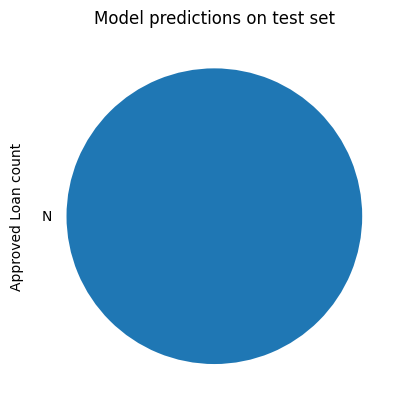

In [128]:
# Test predicitons with test dataset 
test_predictions = model.predict(X_test)

# Save predictions
predictions_df = pd.DataFrame({
    'Loan_ID': test_data.index,
    'Loan_Approval_Status': ['Y' if pred == 1 else 'N' for pred in test_predictions],
})

print(predictions_df['Loan_Approval_Status'].value_counts(normalize=True) * 100)

predictions_pie = predictions_df['Loan_Approval_Status'].value_counts()\
    .plot(kind='pie', title='Model predictions on test set', ylabel="Approved Loan count")